In [25]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

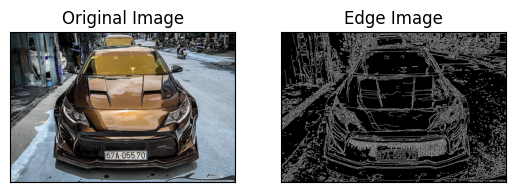

In [26]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

img = cv2.imread('data/test.jpg')
edges = cv2.Canny(img, 100, 200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

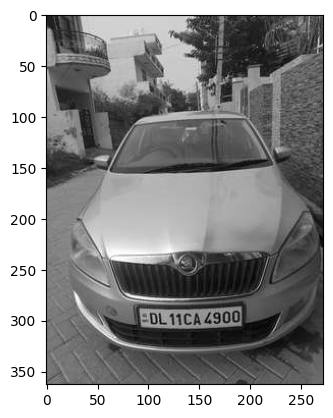

In [27]:
img = cv2.imread('data/DL14.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

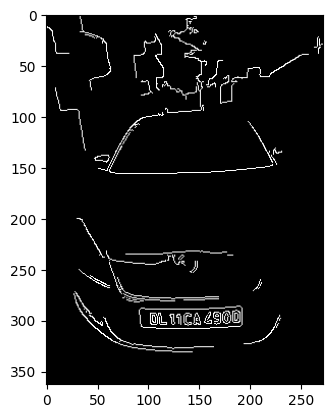

In [28]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 250, 500) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [29]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [30]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [31]:
location

array([[[192, 288]],

       [[ 91, 294]],

       [[ 95, 307]],

       [[178, 307]]], dtype=int32)

In [32]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

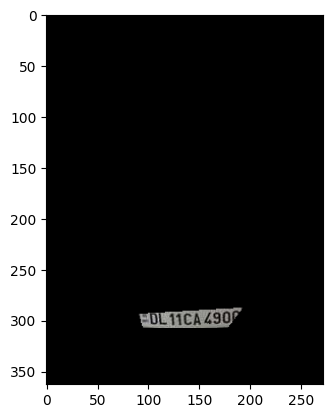

In [33]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [34]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

(20, 102, 3)


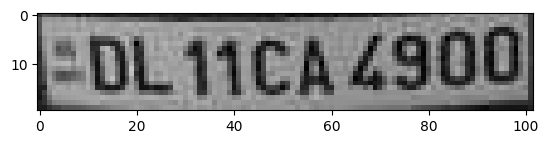

In [35]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2BGR)
print(cropped_image.shape)

In [36]:
def segment_characters(image) :

    # Hình ảnh biển số xe đã cắt tiền xử lý
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Tạo đường viền màu trắng
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Ước tính kích thước đường viền ký tự của biển số xe đã cắt
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [37]:
def find_contours(dimensions, img) :

    # Tìm tất cả các đường viền trong ảnh
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Truy xuất kích thước tiềm năng
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Sắp xếp các đường viền 
    cntrs = sorted(cntrs, key = cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # phát hiện đường viền trong ảnh nhị phân và trả về tọa độ của hình chữ nhật bao quanh nó
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # kiểm tra kích thước của đường viền để lọc ra các ký tự theo kích thước của đường viền
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) # Lưu tọa độ x của đường viền ký tự

            char_copy = np.zeros((44,24))
            # trích xuất từng ký tự bằng tọa độ của hình chữ nhật
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50, 21, 200), 2)
            plt.imshow(ii, cmap='gray')

            # Đảo ngược color
            char = cv2.subtract(255, char)

            # Thay đổi kích thước hình ảnh thành 24x44 với viền đen
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # Danh sách lưu trữ hình ảnh nhị phân của ký tự (chưa sắp xếp)
            
    plt.show()
    # Lưu trữ danh sách các chỉ số ký tự được sắp xếp
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx]) # lưu hình ảnh theo index 
    img_res = np.array(img_res_copy)

    return img_res

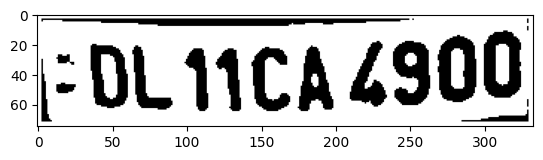

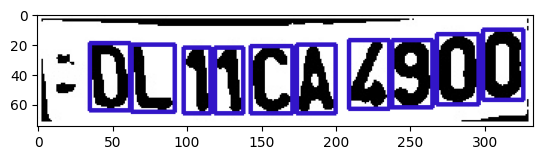

In [38]:
char = segment_characters(cropped_image)
num_characters = len(char)

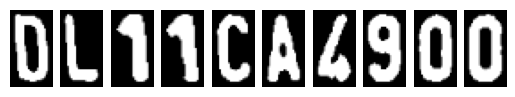

In [39]:
num_characters = len(char)

for i in range(num_characters):
    plt.subplot(1, num_characters, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [40]:
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
json_file = open('models/Model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
model.load_weights("models/License_character_recognition.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('models/license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [41]:
# Dự đoán đầu ra
def fix_dimension(img): 
  new_img = np.zeros((80,80,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in char:  # Lặp qua các ký tự 
        img_ = cv2.resize(ch, (80, 80), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 80, 80, 3)
        y_ = model.predict(img)[0] # dự đoán đầu ra 
        character = dic[np.argmax(y_)] # Tìm số lớp nhất trong y_ 
        output.append(character)  

    plate_number = ''.join(output)

    return plate_number


1/1 [==============================] - 0s 30ms/step
DL11CA4900


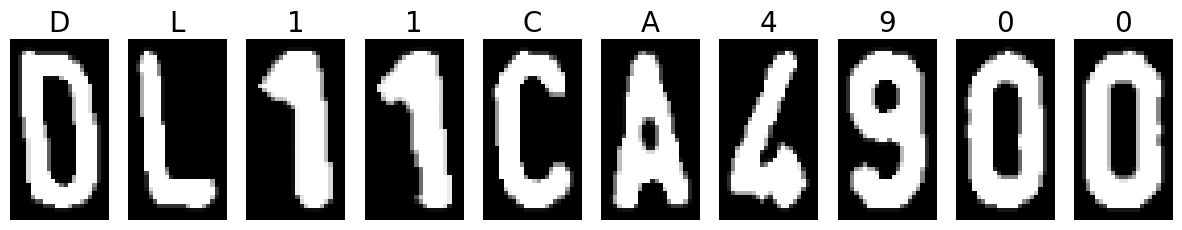

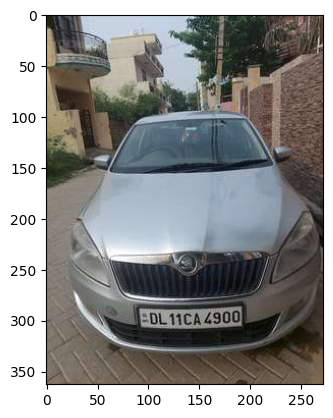

In [42]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15, 3))
cols = len(char)
grid = gridspec.GridSpec(ncols=cols, nrows=1, figure=fig)

final_string = ''
for i, character in enumerate(char):
    fig.add_subplot(grid[i])
    plt.imshow(character, cmap='gray')
    plt.title(f'{show_results([character])}', fontsize=20)
    final_string += show_results([character])
    plt.axis(False)

print(final_string)
plt.show()
output_img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(output_img_rgb)